> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [The No Show Appointment]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

‘ScheduledDay’ tells us on what day the patient set up their appointment.
‘Neighborhood’ indicates the location of the hospital.
‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.


### Question(s) for Analysis
1- What affects the patient to attend again?

2- What is effect of age and gender on probable diseases?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline
# df = pd.read_csv('titanic_data.csv')
# df.head()
# df.shape()
# df.describe()
# df.info()
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
# Reading dataset
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv');
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.shape

(110527, 14)

There is 110527 appointment in the database.

In [5]:
df.duplicated().sum()

0

There is no duplicated rows in the database.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There is no missing values.


In [7]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


It is not logical that there is -1 value in Age column.


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [8]:
#delete rows with abnormal value: Age = -1.
df.drop(df[df['Age'] < 0].index,inplace=True)

In [9]:

# Droping columns that we will not use.
df.drop(['PatientId','AppointmentID'],axis=1,inplace=True)



In [10]:

# Rename incorrect column names.
# df = df.rename(columns={'Hipertension':'Hypertension', 'Handcap':'Handicap','SMS_received':'SMS_received','No-show':'No_show'},inplace=True);




# Summary


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (What affects the patient to attend again?!)

In [11]:
show,noShow=df['No-show']=='No',df['No-show']=='Yes'

In [12]:
df[show].count(),df[noShow].count()

(Gender            88207
 ScheduledDay      88207
 AppointmentDay    88207
 Age               88207
 Neighbourhood     88207
 Scholarship       88207
 Hipertension      88207
 Diabetes          88207
 Alcoholism        88207
 Handcap           88207
 SMS_received      88207
 No-show           88207
 dtype: int64, Gender            22319
 ScheduledDay      22319
 AppointmentDay    22319
 Age               22319
 Neighbourhood     22319
 Scholarship       22319
 Hipertension      22319
 Diabetes          22319
 Alcoholism        22319
 Handcap           22319
 SMS_received      22319
 No-show           22319
 dtype: int64)

In [13]:
df[show].mean(),df[noShow].mean()

(Age             37.790504
 Scholarship      0.093904
 Hipertension     0.204394
 Diabetes         0.073838
 Alcoholism       0.030417
 Handcap          0.022742
 SMS_received     0.291337
 dtype: float64, Age             34.317667
 Scholarship      0.115507
 Hipertension     0.169004
 Diabetes         0.064071
 Alcoholism       0.030333
 Handcap          0.020297
 SMS_received     0.438371
 dtype: float64)

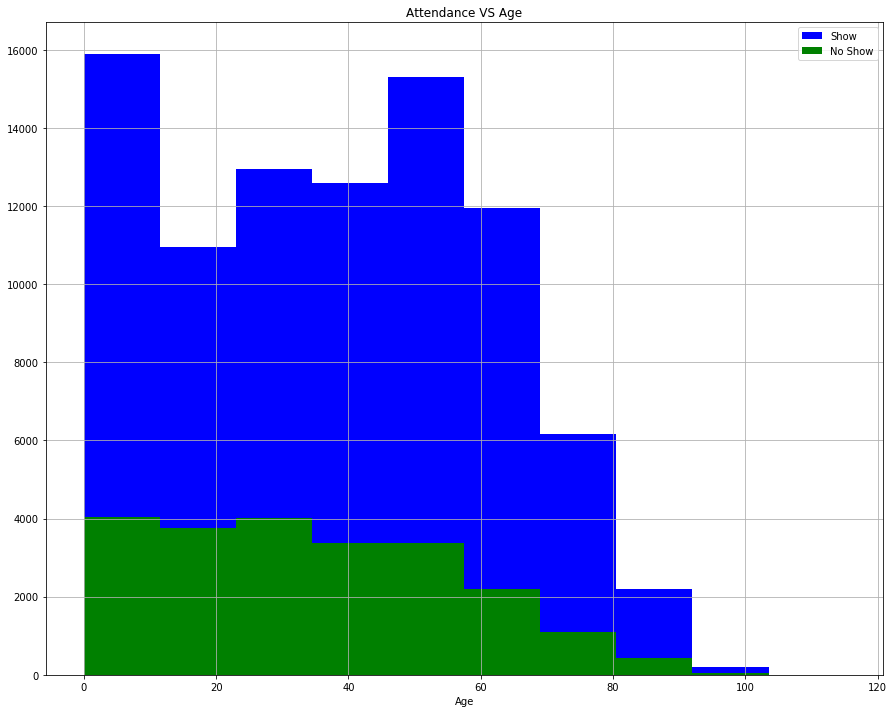

In [14]:
def TwoVariablePlot(title,xCol,yCol1,ylabel1,yCol2,ylabel2):
    plt.figure(figsize=(15,12))
    df[xCol][yCol1].hist(alpha=1,color='blue',label=ylabel1)   
    df[xCol][yCol2].hist(alpha=1,color='green',label=ylabel2)
    plt.legend()
    plt.title(title)
    plt.xlabel(xCol)
TwoVariablePlot('Attendance VS Age','Age',show,'Show',noShow,'No Show')

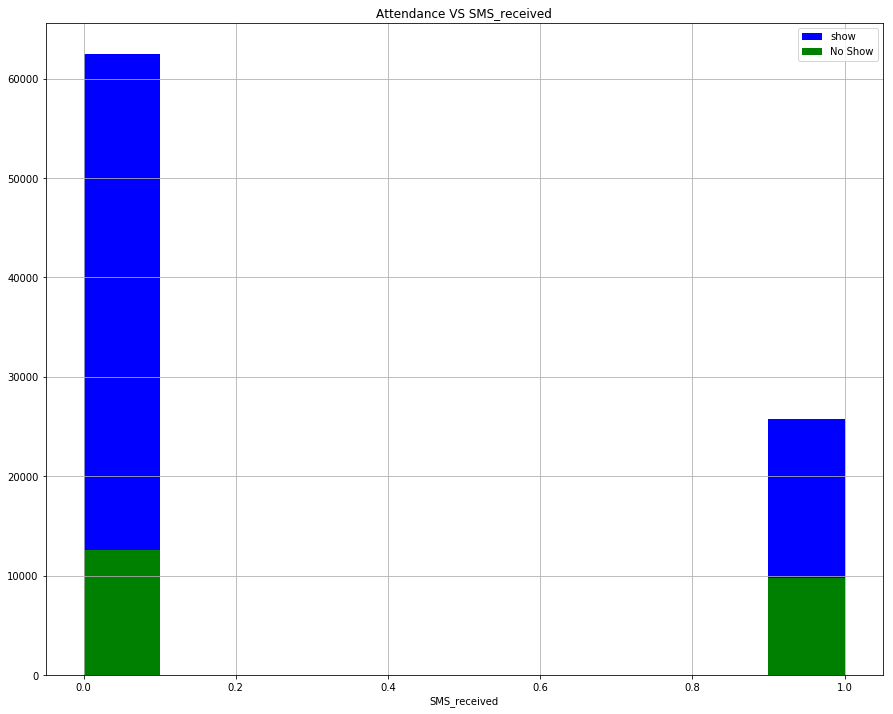

In [15]:
TwoVariablePlot('Attendance VS SMS_received','SMS_received',show,'show',noShow,'No Show')

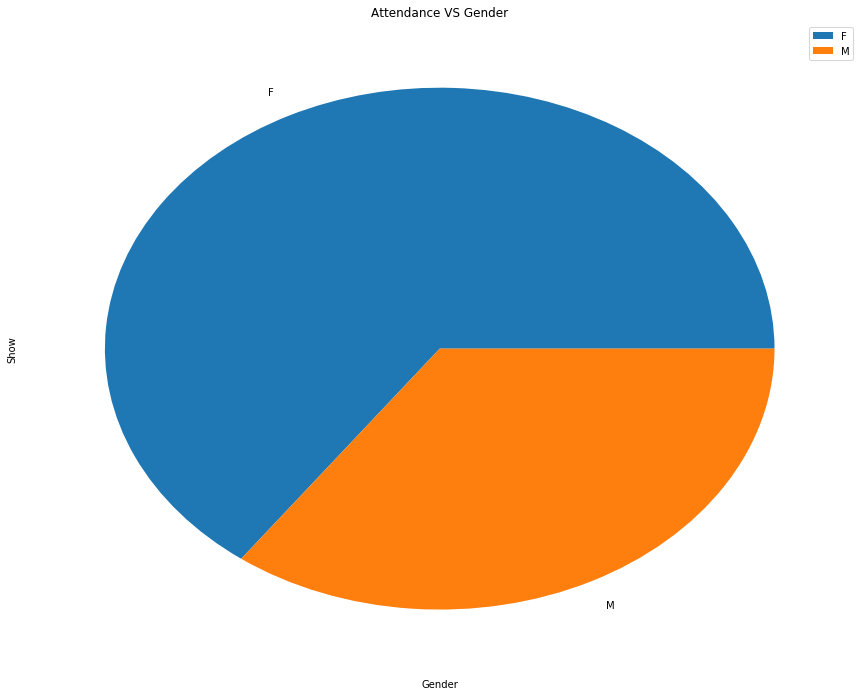

In [19]:
def Attendance(title,xCol,yCol,ylabel):
    plt.figure(figsize=(15,12))
    df[xCol][yCol].value_counts(normalize=True).plot(kind='pie',label=ylabel)   
    plt.legend();
    plt.title(title)
    plt.xlabel(xCol)
Attendance('Attendance VS Gender','Gender',show,'Show')

Age And SMS_received has an effect on show
Gender has no effect on attendance

### Research Question 2  (What is effect of age and gender on probable diseases?)

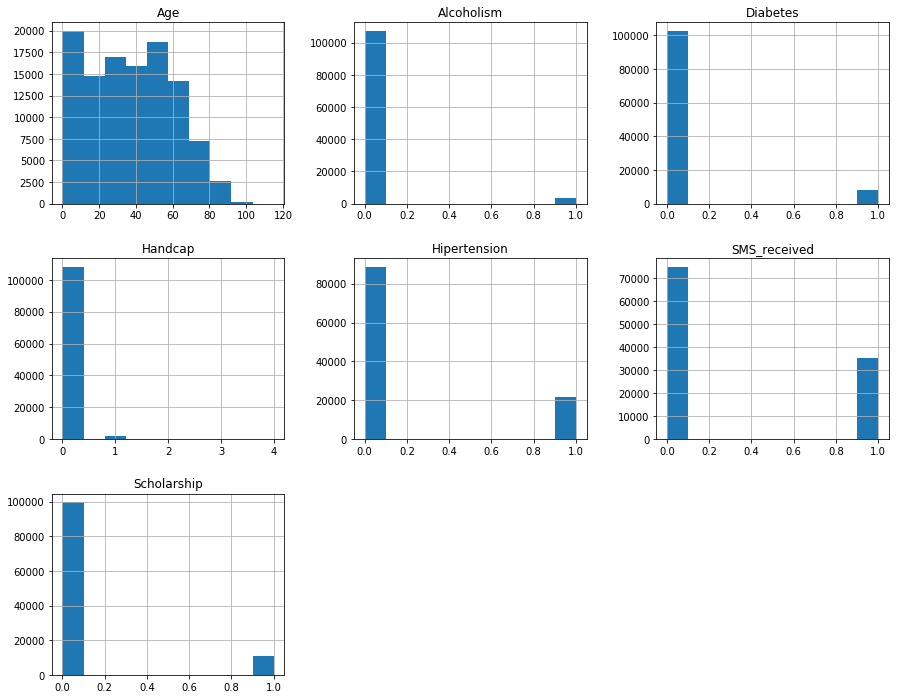

In [20]:
df.hist(figsize=(15,12));

In [ ]:
def diseaseYes(disease):
    yes=df[disease]==1
    return yes
def diseaseNo(disease):
    no=df[disease]==0
    return no
    
def DiseasePlots(title,yCol,Disease1,Disease2,Disease3,Disease4):
    plt.figure(figsize=(15,12))
    df[diseaseYes(Disease1)][yCol].plot(kind='bar',color='blue',label=Disease1)     
    df[diseaseNo(Disease1)][yCol].plot(kind='bar',color='green',label=Disease1)   

#     df[diseaseYes(Disease2)].mean()[yCol].plot(kind='bar',color='green',label=Disease2)    
#     df[diseaseNo(Disease2)].mean()[yCol].plot(color='green',label=Disease2)  

    
#     df[diseaseYes(Disease3)].mean()[yCol].plot(kind='bar',color='yellow',label=Disease3)  
#     df[diseaseNo(Disease3)].mean()[yCol].plot(color='yellow',label=Disease3)

#     df[diseaseYes(Disease4)].mean()[yCol].plot(kind='bar',color='red',label=Disease4)    
#     df[diseaseNo(Disease4)].mean()[yCol].plot(kind='bar',color='red',label=Disease4)


    plt.legend();
    plt.title(title)
    plt.ylabel(yCol)
DiseasePlots('AGe VS Diseases','Age','Hipertension','Diabetes','Alcoholism','Handcap')


In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> Age has an effect on attendance.

> The hospital must take care in doing the SMS.

> Number of people having Hypertion is bigger that any disease, this mean we know that we have hypertension easly.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])